## Empirical estimate of program effect

In this file, empirical methods are applied to analyze the effect of the small business training program

### Packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as smf

In [2]:
def fit_wls(formula_str):
    mod = smf.wls(f'log_prod ~ {formula_str}', data=df, weights=df['sw'])
    res = mod.fit(cov_type='cluster', cov_kwds={'groups': df['firm_id']})
    return res

def stars(p):
    return '***' if p<0.01 else ('**' if p<0.05 else ('*' if p<0.10 else ''))

def smd(x_t, x_c, w_t=None, w_c=None):
    if w_t is None: w_t = np.ones_like(x_t, dtype=float)
    if w_c is None: w_c = np.ones_like(x_c, dtype=float)
    mt = np.average(x_t, weights=w_t); mc = np.average(x_c, weights=w_c)
    vt = np.average((x_t-mt)**2, weights=w_t); vc = np.average((x_c-mc)**2, weights=w_c)
    return (mt-mc)/np.sqrt(0.5*(vt+vc))

def mark(v): return r'\cmark' if v else r'\xmark'


### Propensity score with DID

#### Read in data

In [3]:
df = pd.read_csv('aggregate_firm_final_cleaned.csv')
# make sure that date is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['firm_id','date']).copy()
df['post'] = (df['date'] >= pd.Timestamp('2013-01-01')).astype(int)

# Here for productivity level, we use sales per employee as a proxy
for col in ['revenue_t','employment_t','adopt_t', 'sales_t', 'wage_bill_t']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['prod'] = df['revenue_t'] / df['employment_t']
df['log_prod'] = np.log(df['prod'])

# drop observations with missing productivity level
df = df.dropna(subset=['log_prod']).copy()

# cross product term for diff-in-diff
firm_post_adopt = (
    df.loc[df['post']==1]
      .groupby('firm_id')['adopt_t'].max()
      .rename('treat')
      .fillna(0)
      .astype(int)
)
df = df.merge(firm_post_adopt, on='firm_id', how='left')
df['treat'] = df['treat'].fillna(0).astype(int)
df['did'] = df['treat'] * df['post']

In [4]:
# Since firms opt to be in such a program, to avoid selection bias, we use PSM to create a control group
pre = df.loc[df['post']==0].copy()
agg_cov = (
    pre.groupby('firm_id')
       .agg(
            emp_mean = ('employment_t','mean'),
            rev_mean = ('revenue_t','mean'),
            sales_mean = ('sales_t','mean') if 'sales_t' in pre.columns else ('revenue_t','mean'),
            emp_std = ('employment_t','std'),
            rev_std = ('revenue_t','std')
       )
       .reset_index()
)

# use the mean value before 2013 as baseline
pre['year'] = pre['date'].dt.year
base = pre.loc[pre['year']<2013].groupby('firm_id').agg(
    emp_2012=('employment_t','mean'),
    rev_2012=('revenue_t','mean')
).reset_index()

sector = pre.groupby('firm_id')['firm_sector'].agg(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan).reset_index()
X_firm = (
    firm_post_adopt.reset_index()
    .merge(agg_cov, on='firm_id', how='left')
    .merge(base, on='firm_id', how='left')
    .merge(sector, on='firm_id', how='left')
)

# Fill the missing values in covariates with mean/median
num_cols = ['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']
for c in num_cols:
    if c in X_firm.columns:
        X_firm[c] = pd.to_numeric(X_firm[c], errors='coerce')
        X_firm[c] = X_firm[c].fillna(X_firm[c].median())
# Categorical columns
cat_cols = ['firm_sector'] if 'firm_sector' in X_firm.columns else []
y = X_firm['treat'].values

# PSM model
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=True, with_std=True), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ],
    remainder='drop'
)

ps_model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

ps_model.fit(X_firm[num_cols + cat_cols], y)
ps = ps_model.predict_proba(X_firm[num_cols + cat_cols])[:,1]
X_firm['ps'] = ps

print(f'Propensity score AUC: {roc_auc_score(y, ps):.3f}')

Propensity score AUC: 0.893


In [5]:
# Trim extreme PS values and stabilize weights
X_firm = X_firm[(X_firm['ps']>0.05) & (X_firm['ps']<0.95)].copy()
pbar = X_firm['treat'].mean()
X_firm['sw'] = np.where(
    X_firm['treat']==1,
    pbar / X_firm['ps'],
    (1-pbar) / (1 - X_firm['ps'])
)
# get weight back to the panel
df = df.merge(X_firm[['firm_id','ps','sw']], on='firm_id', how='inner')

In [6]:
# Main DID regression with PS weights
if 't' not in df.columns:
    df['t'] = df['date'].dt.to_period('M').astype(int)

specs = [
    {'name': '(1)', 'formula': 'did',                                              'firm_fe': False, 'time_fe': False, 'sect_trend': False},
    {'name': '(3)', 'formula': 'did + C(firm_id)',                                 'firm_fe': True,  'time_fe': False, 'sect_trend': False},
    {'name': '(4)', 'formula': 'did + C(firm_id) + C(date)',                       'firm_fe': True,  'time_fe': True,  'sect_trend': False},
    {'name': '(5)', 'formula': 'did + C(firm_id) + C(date) + C(firm_sector):t',    'firm_fe': True,  'time_fe': True,  'sect_trend': True},
]

results = []
for s in specs:
    res = fit_wls(s['formula'])
    b = float(res.params.get('did', np.nan))
    se = float(res.bse.get('did', np.nan))
    p = float(res.pvalues.get('did', np.nan))
    results.append({
        'name': s['name'], 'b': b, 'se': se, 'p': p,
        'firm_fe': s['firm_fe'], 'time_fe': s['time_fe'], 'sect_trend': s['sect_trend'],
        'n': int(res.nobs), 'r2': float(getattr(res, 'rsquared', np.nan))
    })

In [7]:
# LaTeX table
colN = len(results)
header_specs = ' & ' + ' & '.join(r['name'] for r in results) + r' \\'
coef_row = 'Post*Treat'
coef_vals = ' & '.join([f"{r['b']:.3f}{stars(r['p'])}" for r in results])
se_vals = ' & '.join([f"({r['se']:.3f})" for r in results])

firm_fe_row = 'Firm fixed effects'
firm_fe_vals = ' & '.join([mark(r['firm_fe']) for r in results])
time_fe_row = 'Time fixed effects'
time_fe_vals = ' & '.join([mark(r['time_fe']) for r in results])
sect_trend_row = 'Sector * Time trend'
sect_trend_vals = ' & '.join([mark(r['sect_trend']) for r in results])

n_row = 'N'
n_vals = ' & '.join([f"{r['n']:,}" for r in results])
r2_row = r'$R^2$'
r2_vals = ' & '.join([f"{r['r2']:.3f}" if np.isfinite(r['r2']) else '' for r in results])

latex_table = rf"""
\begin{{table}}[!htbp]\centering
\caption{{PSM-DID Estimation Results}}
\label{{tab:did_specs}}
\begin{{threeparttable}}
\begin{{tabular}}{{l*{{{colN}}}{{c}}}}
\toprule
 & {header_specs}
\midrule
{coef_row} & {coef_vals} \\
           & {se_vals} \\
\midrule
{firm_fe_row} & {firm_fe_vals} \\
{time_fe_row} & {time_fe_vals} \\
{sect_trend_row} & {sect_trend_vals} \\
\midrule
{n_row} & {n_vals} \\
{r2_row} & {r2_vals} \\
\bottomrule
\end{{tabular}}
\begin{{tablenotes}}[flushleft]
\footnotesize
\item Note: Dependent variable is the logarithm of productivity, and all models use propensity score stabilized weights (WLS), with standard errors clustered at the firm level. Robust standard errors are reported in parentheses. $^{{***}}p<0.01$, $^{{**}}p<0.05$, $^{{*}}p<0.10$.
\end{{tablenotes}}
\end{{threeparttable}}
\end{{table}}
""".strip()

out_dir = os.path.join(os.getcwd(), 'table')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'psm_did_drop.tex')
with open(out_path, 'w') as f:
    f.write(latex_table)


In [8]:
# Get the direct parameter estimate and 95% CI
tau = res.params.get('did', np.nan)
se = res.bse.get('did', np.nan)
ci_low = tau - 1.96*se
ci_high = tau + 1.96*se
print(f"log(productivity) increases by: {tau:.4f}, 95% CI [{ci_low:.4f}, {ci_high:.4f}] after adopting the program")

log(productivity) increases by: 0.3964, 95% CI [0.3256, 0.4672] after adopting the program


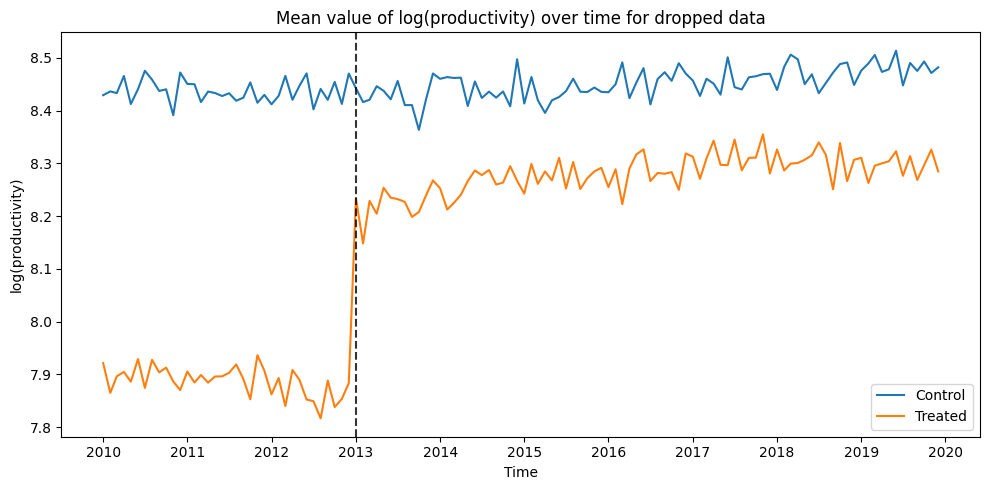

In [9]:
# Visualization of PSM distribution
trend = (
    df.groupby(['date','treat'])['log_prod']
      .mean()
      .reset_index()
)
plt.figure(figsize=(10,5))
for g, d in trend.groupby('treat'):
    label = 'Treated' if g==1 else 'Control'
    plt.plot(d['date'], d['log_prod'], label=label)
plt.axvline(pd.Timestamp('2013-01-01'), color='k', linestyle='--', alpha=0.8)
plt.title('Mean value of log(productivity) over time for dropped data')
plt.xlabel('Time')
plt.ylabel('log(productivity)')
plt.legend()
plt.tight_layout()
plt.show()

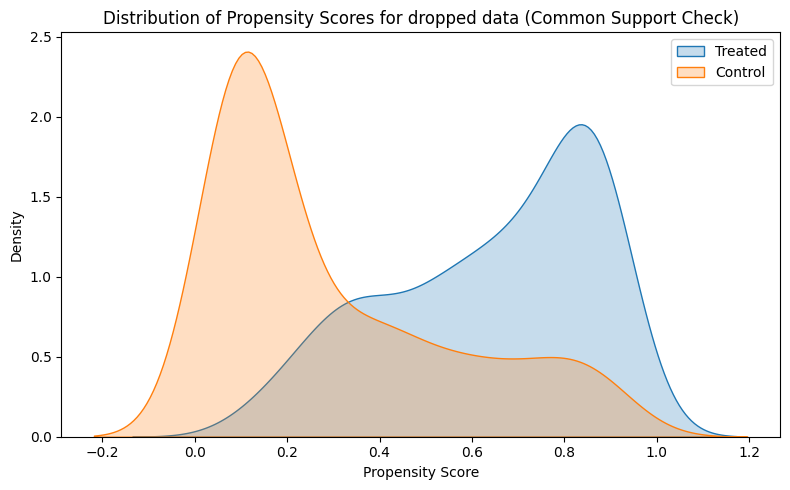

In [10]:
# PS distribution check
plt.figure(figsize=(8,5))
sns.kdeplot(X_firm.loc[X_firm['treat']==1,'ps'], label='Treated', fill=True)
sns.kdeplot(X_firm.loc[X_firm['treat']==0,'ps'], label='Control', fill=True)
plt.title('Distribution of Propensity Scores for dropped data (Common Support Check)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

       cov   smd_unw     smd_w
  emp_mean -1.407545 -0.086424
  rev_mean -1.297195 -0.073606
sales_mean -1.348272 -0.052791
   emp_std -1.285934 -0.045072
   rev_std -1.169345 -0.039749
  emp_2012 -1.407545 -0.086424
  rev_2012 -1.297195 -0.073606


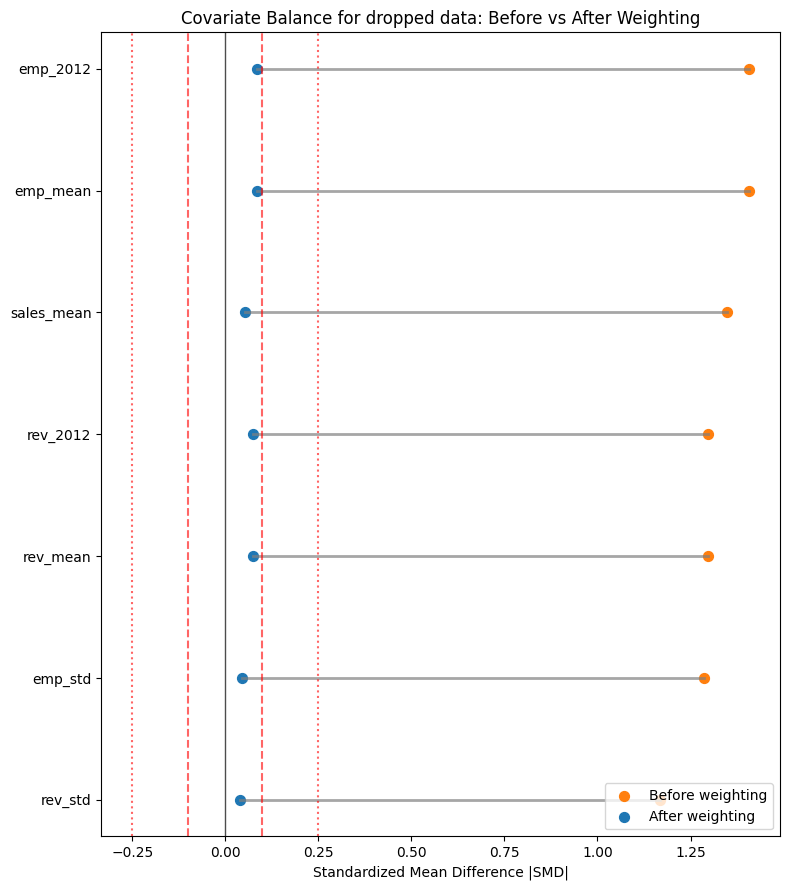

In [11]:
covs = ['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']
tmp = X_firm.copy()
rows = []
for c in covs:
    a = pd.to_numeric(tmp.loc[tmp['treat']==1, c], errors='coerce').dropna()
    b = pd.to_numeric(tmp.loc[tmp['treat']==0, c], errors='coerce').dropna()
    wa = tmp.loc[a.index, 'sw'].fillna(1).to_numpy()
    wb = tmp.loc[b.index, 'sw'].fillna(1).to_numpy()

    smd_unw = smd(a.to_numpy(), b.to_numpy())
    smd_w   = smd(a.to_numpy(), b.to_numpy(), wa, wb)
    rows.append({'cov': c, 'smd_unw': smd_unw, 'smd_w': smd_w})

# Balance table
bal_df = pd.DataFrame(rows)
bal_df['abs_unw'] = bal_df['smd_unw'].abs()
bal_df['abs_w']   = bal_df['smd_w'].abs()
print(bal_df[['cov','smd_unw','smd_w']].to_string(index=False))

# Balance plot
order = bal_df.sort_values('abs_unw', ascending=True)['cov'].tolist()
plt.figure(figsize=(8, 1.0*len(order) + 2))
for i, cov in enumerate(order):
    x0 = bal_df.loc[bal_df['cov']==cov, 'abs_unw'].values[0]
    x1 = bal_df.loc[bal_df['cov']==cov, 'abs_w'].values[0]
    plt.plot([x0, x1], [i, i], color='gray', linewidth=2, alpha=0.7)
    plt.scatter(x0, i, color='tab:orange', s=50, label='Before weighting' if i==0 else "")
    plt.scatter(x1, i, color='tab:blue', s=50, label='After weighting' if i==0 else "")

for thr, ls in [(0.1, '--'), (0.25, ':')]:
    plt.axvline(thr, color='red', linestyle=ls, alpha=0.6)
    plt.axvline(-thr, color='red', linestyle=ls, alpha=0.6)
plt.axvline(0, color='k', linewidth=1, alpha=0.7)

plt.yticks(range(len(order)), order)
plt.xlabel('Standardized Mean Difference |SMD|')
plt.title('Covariate Balance for dropped data: Before vs After Weighting')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [12]:
# Event analysis for parallel trends check
month_index = df['date'].dt.to_period('M').astype(int)
t0 = pd.Period('2013-01', freq='M').ordinal  
df['rel_m'] = month_index - t0

# consider a window of +- 24 months
df_es = df[(df['rel_m']>=-24) & (df['rel_m']<=24)].copy()

# Create lead/lag indicators
for k in range(-24, 25):
    if k == -1:
        continue
    df_es[f'leadlag_{k}'] = ((df_es['rel_m']==k) & (df_es['treat']==1)).astype(int)

# Key regression for event study
terms = ' + '.join([f"Q('leadlag_{k}')" for k in range(-24, 25) if k != -1])
formula_es = f'log_prod ~ {terms} + C(firm_sector) + C(date)'
mod_es = smf.wls(formula_es, data=df_es, weights=df_es['sw'])
res_es = mod_es.fit(cov_type='cluster', cov_kwds={'groups': df_es['firm_id']})


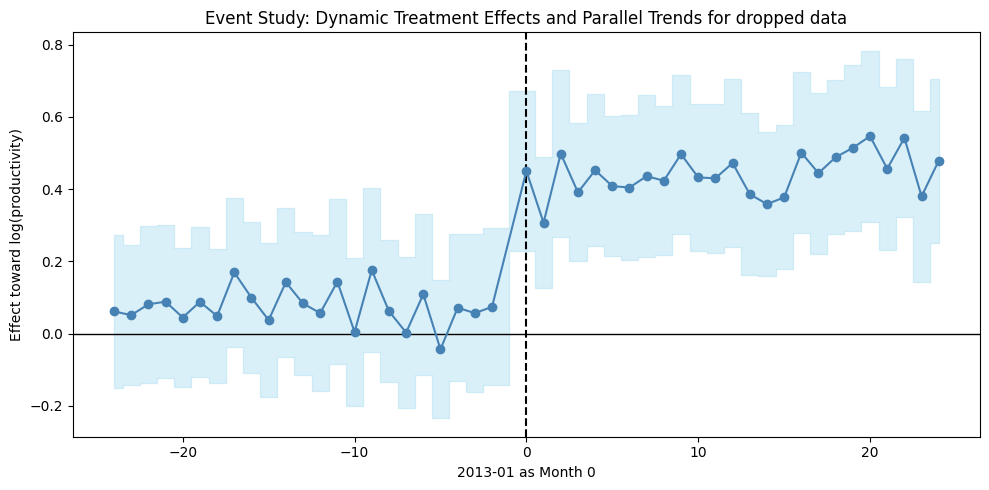

In [13]:
# Get coefficients and CIs
betas, lower, upper, rel = [], [], [], []
for k in range(-24, 25):
    if k == -1:
        continue
    name = f"Q('leadlag_{k}')"
    b = res_es.params.get(name, np.nan)
    se = res_es.bse.get(name, np.nan)
    if pd.notna(b) and pd.notna(se):
        betas.append(b)
        lower.append(b - 1.96*se)
        upper.append(b + 1.96*se)
        rel.append(k)

# Plot event study results
es_df = pd.DataFrame({'rel_m': rel, 'beta': betas, 'lo': lower, 'hi': upper}).sort_values('rel_m')

plt.figure(figsize=(10,5))
plt.axhline(0, color='k', linewidth=1)
plt.axvline(0, color='k', linestyle='--')
plt.fill_between(es_df['rel_m'], es_df['lo'], es_df['hi'], color='skyblue', alpha=0.3, step='mid')
plt.plot(es_df['rel_m'], es_df['beta'], color='steelblue', marker='o')
plt.title('Event Study: Dynamic Treatment Effects and Parallel Trends for dropped data')
plt.xlabel('2013-01 as Month 0')
plt.ylabel('Effect toward log(productivity)')
plt.tight_layout()
plt.show()

In [14]:
# Joint test for pre-trends
pre_coefs = [f"Q('leadlag_{k}')" for k in range(-24, 0) if k != -1]
if len(pre_coefs) > 0:
    R = np.zeros((len(pre_coefs), len(res_es.params)))
    param_names = res_es.params.index.tolist()
    rows = []
    for i, name in enumerate(pre_coefs):
        if name in param_names:
            j = param_names.index(name)
            R[i, j] = 1.0
            rows.append(name)
    if rows:
        wald = res_es.wald_test(R, use_f=True, scalar=True)
        print('Parallel Trends (Joint Test for Pre-Trends):', wald)

Parallel Trends (Joint Test for Pre-Trends): <F test: F=1.4247236914654622, p=0.09478360023116668, df_denom=359, df_num=23>


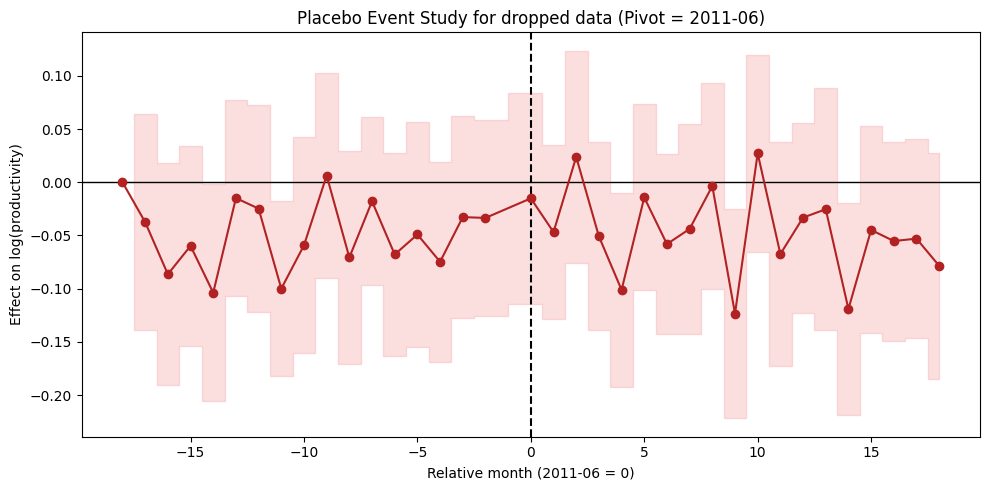

In [15]:
# Placebo test
t0_placebo = pd.Period('2011-06', freq='M').ordinal
df['rel_m_pl'] = df['date'].dt.to_period('M').astype(int) - t0_placebo
df_pl = df[(df['rel_m_pl']>=-18) & (df['rel_m_pl']<=18)].copy()
for k in range(-18, 19):
    if k == -1: continue
    df_pl[f'pl_{k}'] = ((df_pl['rel_m_pl']==k) & (df_pl['treat']==1)).astype(int)
terms_pl = ' + '.join([f"Q('pl_{k}')" for k in range(-18, 19) if k != -1])
res_pl = smf.wls(f'log_prod ~ {terms_pl} + C(firm_id) + C(date)',
                 data=df_pl, weights=df_pl['sw']).fit(cov_type='cluster', cov_kwds={'groups': df_pl['firm_id']})

betas_pl, lower_pl, upper_pl, rel_pl = [], [], [], []
for k in range(-18, 19):
    if k == -1: 
        continue
    name = f"Q('pl_{k}')"
    b = res_pl.params.get(name, np.nan)
    se = res_pl.bse.get(name, np.nan)
    if pd.notna(b) and pd.notna(se):
        betas_pl.append(b); lower_pl.append(b - 1.96*se); upper_pl.append(b + 1.96*se); rel_pl.append(k)

es_pl_df = pd.DataFrame({'rel_m': rel_pl, 'beta': betas_pl, 'lo': lower_pl, 'hi': upper_pl}).sort_values('rel_m')

plt.figure(figsize=(10,5))
plt.axhline(0, color='k', linewidth=1)
plt.axvline(0, color='k', linestyle='--')
plt.fill_between(es_pl_df['rel_m'], es_pl_df['lo'], es_pl_df['hi'], color='lightcoral', alpha=0.25, step='mid')
plt.plot(es_pl_df['rel_m'], es_pl_df['beta'], color='firebrick', marker='o')
plt.title('Placebo Event Study for dropped data (Pivot = 2011-06)')
plt.xlabel('Relative month (2011-06 = 0)')
plt.ylabel('Effect on log(productivity)')
plt.tight_layout()
plt.show()


### Matching score DID

logit(ps) SD=1.5812, caliper=0.2*SD=0.3162
Matching successful: 169/169 treated (caliper= 0.3162)


/Users/wangchengrui11/Desktop/PhD_application/Stanford_Data_Task_2025/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 350, but rank is 120
  warnings.warn('covariance of constraints does not have full '


                            WLS Regression Results                            
Dep. Variable:               log_prod   R-squared:                       0.832
Model:                            WLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     457.5
Date:                Tue, 30 Sep 2025   Prob (F-statistic):          2.71e-227
Time:                        17:41:17   Log-Likelihood:                -7217.0
No. Observations:               25053   AIC:                         1.514e+04
Df Residuals:                   24702   BIC:                         1.799e+04
Df Model:                         350                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

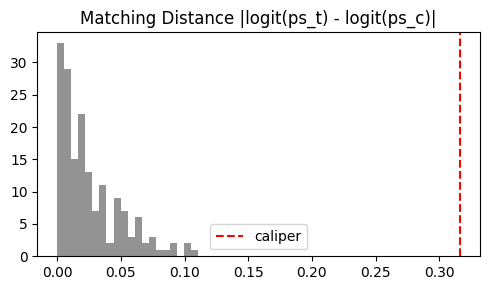

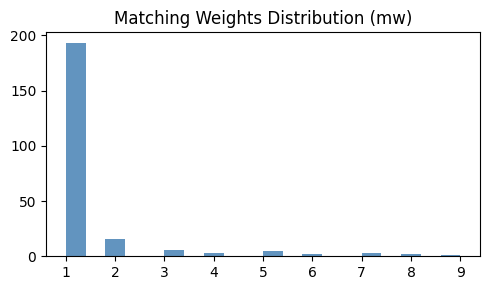

In [16]:
# Nearest Neighbor Matching with Caliper on logit(PS)

# Calculate logit(ps) and caliper
eps = 1e-6
X_firm['ps_clip'] = X_firm['ps'].clip(eps, 1-eps)
X_firm['logit_ps'] = np.log(X_firm['ps_clip']/(1 - X_firm['ps_clip']))
sd_logit = X_firm['logit_ps'].std(ddof=1)
caliper = 0.2 * sd_logit
print(f'logit(ps) SD={sd_logit:.4f}, caliper=0.2*SD={caliper:.4f}')

# Nearest Neighbor Matching within Caliper
treated = X_firm.loc[X_firm['treat']==1, ['firm_id','logit_ps']].reset_index(drop=True)
control = X_firm.loc[X_firm['treat']==0, ['firm_id','logit_ps']].reset_index(drop=True)

if len(treated)==0 or len(control)==0:
    raise RuntimeError('Matching not possible: no treated or control units after trimming')

nn = NearestNeighbors(n_neighbors=1).fit(control[['logit_ps']].to_numpy())
dist, idx = nn.kneighbors(treated[['logit_ps']].to_numpy(), n_neighbors=1, return_distance=True)
dist = dist.ravel(); idx = idx.ravel()

# Match pairs within caliper
pairs = []
for i, (d, j) in enumerate(zip(dist, idx)):
    if d <= caliper:
        t_id = treated.loc[i, 'firm_id']
        c_id = control.loc[j, 'firm_id']
        pairs.append({'treated_id': t_id, 'control_id': c_id, 'abs_logit_diff': float(d)})

pairs = pd.DataFrame(pairs)
matched_t = pairs['treated_id'].nunique() if not pairs.empty else 0
print(f'Matching successful: {matched_t}/{len(treated)} treated (caliper= {caliper:.4f})')

if pairs.empty:
    raise RuntimeError('Matching not possible: no pairs found within caliper')

# 4) Generate matching weights and map back to panel
ctrl_weight = pairs.groupby('control_id').size().rename('mw').reset_index()
treat_weight = pairs[['treated_id']].drop_duplicates().assign(mw=1).rename(columns={'treated_id':'firm_id'})
ctrl_weight = ctrl_weight.rename(columns={'control_id':'firm_id'})
mw = pd.concat([treat_weight, ctrl_weight], ignore_index=True)

matched_ids = set(mw['firm_id'])
df_m = df[df['firm_id'].isin(matched_ids)].copy()
df_m = df_m.merge(mw, on='firm_id', how='left')
df_m['mw'] = df_m['mw'].fillna(0)

# 5) Run DID (firm FE + time FE) on matched sample
mod_m = smf.wls('log_prod ~ did + C(firm_id) + C(date)', data=df_m, weights=df_m['mw'])
res_m = mod_m.fit(cov_type='cluster', cov_kwds={'groups': df_m['firm_id']})
print(res_m.summary().as_text())

tau_m = res_m.params.get('did', np.nan)
se_m  = res_m.bse.get('did', np.nan)
print(f'[Matching DID-logit Caliper] did={tau_m:.4f}, 95%CI [{tau_m-1.96*se_m:.4f}, {tau_m+1.96*se_m:.4f}]; matched firms={len(matched_ids)}')

# 6) Visualizations for matching quality
plt.figure(figsize=(5,3))
plt.hist(pairs['abs_logit_diff'], bins=20, color='gray', alpha=0.85)
plt.axvline(caliper, color='red', linestyle='--', label='caliper')
plt.title('Matching Distance |logit(ps_t) - logit(ps_c)|')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3))
plt.hist(mw['mw'], bins=20, color='steelblue', alpha=0.85)
plt.title('Matching Weights Distribution (mw)'); plt.tight_layout(); plt.show()

### DR-DID

In [17]:
# Augmented Inverse Probability Weighting (AIPW) / Doubly Robust DID (DR-DID) estimation

pre_df  = df.loc[df['post']==0, ['firm_id','log_prod']].groupby('firm_id', as_index=False)['log_prod'].mean().rename(columns={'log_prod':'y_pre'})
post_df = df.loc[df['post']==1, ['firm_id','log_prod']].groupby('firm_id', as_index=False)['log_prod'].mean().rename(columns={'log_prod':'y_post'})
dd = pre_df.merge(post_df, on='firm_id', how='inner')
dd['dY'] = dd['y_post'] - dd['y_pre']

# Synthesize by covariating
base_cols = ['firm_id','treat','ps'] + ['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012','firm_sector']
z = dd.merge(X_firm[base_cols], on='firm_id', how='inner').dropna(subset=['ps','treat'])

# Characteristics for outcome regression
Z = z[['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']].copy()
if 'firm_sector' in z.columns:
    Z = pd.concat([Z, pd.get_dummies(z['firm_sector'], prefix='sec', drop_first=True)], axis=1).astype(float)

# Outcome model: Fit E[dY|X] using control group only
ctrl = z['treat']==0
reg = LinearRegression().fit(Z[ctrl], z.loc[ctrl, 'dY'])
mhat = reg.predict(Z)

# AIPW/DR-DID ATT
T = z['treat'].values.astype(int)
ps = z['ps'].clip(1e-6, 1-1e-6).values
dY = z['dY'].values
resid = dY - mhat

# Normalize weights (control group)
w_ctrl = ps/(1-ps)
w_ctrl_norm = w_ctrl[~T.astype(bool)]
w_ctrl_norm = w_ctrl_norm / w_ctrl_norm.sum()

att_treated = resid[T==1].mean()
att_control = np.sum(w_ctrl_norm * resid[T==0])
att_dr = att_treated - att_control
print(f'[AIPW-DRDID] ATT_DR={att_dr:.4f} (point estimate)')

# Simple firm-level bootstrap CI
B = 200
rng = np.random.default_rng(42)
boot = []
firm_ids = z['firm_id'].unique()
for _ in range(B):
    samp = rng.choice(firm_ids, size=len(firm_ids), replace=True)
    zz = z.set_index('firm_id').loc[samp].reset_index()

    ZZ = zz[['emp_mean','rev_mean','sales_mean','emp_std','rev_std','emp_2012','rev_2012']].copy()
    if 'firm_sector' in zz.columns:
        ZZ = pd.concat([ZZ, pd.get_dummies(zz['firm_sector'], prefix='sec', drop_first=True)], axis=1).astype(float)

    T_b  = zz['treat'].values.astype(int)
    ps_b = zz['ps'].clip(1e-6, 1-1e-6).values
    dY_b = zz['dY'].values

    reg_b = LinearRegression().fit(ZZ[T_b==0], dY_b[T_b==0])
    mhat_b = reg_b.predict(ZZ)
    resid_b = dY_b - mhat_b

    w_b = ps_b/(1-ps_b)
    w_b_norm = w_b[T_b==0]; w_b_norm = w_b_norm / w_b_norm.sum()

    att_b = resid_b[T_b==1].mean() - np.sum(w_b_norm * resid_b[T_b==0])
    boot.append(att_b)

boot = np.array(boot)
se_dr = boot.std(ddof=1)
ci_lo, ci_hi = att_dr - 1.96*se_dr, att_dr + 1.96*se_dr
print(f'[AIPW-DRDID] 95% CI [{ci_lo:.4f}, {ci_hi:.4f}] (B={B} bootstrap)')

[AIPW-DRDID] ATT_DR=0.4259 (point estimate)
[AIPW-DRDID] 95% CI [0.3519, 0.5000] (B=200 bootstrap)


### 